# EDA and Data Visualization (Daily Trends)

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression

In [23]:
building_nr = "all"

# Load data
if building_nr == 'all':
    df = pd.read_csv(f"../data/preprocessed/Agg_buildings.csv").astype({'datetime': 'datetime64'}).set_index('datetime')
else:
    df = pd.read_csv(f"../data/preprocessed/Building_{building_nr}.csv").astype({'datetime': 'datetime64'}).set_index('datetime')
df.fillna(0.0, inplace=True)

In [24]:
df.head()

,daylight_savings,indoor_temp,avg_unmet_cooling_temp,indoor_hum,equipment_electric_power_kW,dhw_heating_kW,cooling_load_kW,solar_generation_W_kW,outdoor_temp,outdoor_hum,...,pred_12h_diffuse_solar_W_m2,pred_24h_diffuse_solar_W_m2,pred_6h_direct_solar_W_m2,pred_12h_direct_solar_W_m2,pred_24h_direct_solar_W_m2,holiday,workday,solar_generation_kW,electric_load_hp_kW,net_load_kW
datetime,,,,,,,,,,,,,,,,,,,,,
2008-01-02 00:00:00,0.0,21.516667,0.0,55.982222,81.89,8.76,12.50,0.0,9.40,94.12,...,170.84,0.0,-0.00,5.32,0.0,True,False,0.0,1.318,91.968
2008-01-02 01:00:00,0.0,21.528889,0.0,54.130000,58.64,10.08,5.25,0.0,7.61,93.00,...,112.24,0.0,1.11,2.04,-0.0,True,False,0.0,0.328,69.048
2008-01-02 02:00:00,0.0,21.581111,0.0,53.107778,62.97,1.56,5.47,0.0,8.11,93.00,...,65.93,0.0,1.74,1.04,0.0,True,False,0.0,0.408,64.938
2008-01-02 03:00:00,0.0,21.437778,0.0,51.641111,61.86,3.96,4.87,0.0,8.36,93.00,...,38.59,-0.0,1.09,0.99,0.0,True,False,0.0,0.392,66.212
2008-01-02 04:00:00,0.0,21.425556,0.0,50.933333,59.99,1.56,5.41,0.0,8.78,93.00,...,15.92,0.0,1.78,0.84,0.0,True,False,0.0,0.490,62.040


In [146]:
# Add a total load
df['total_load_kW'] = df['equipment_electric_power_kW'] + df['dhw_heating_kW'] + df['cooling_load_kW']

# Add a total load without cooling
df['total_load_wo_cooling_kW'] = df['equipment_electric_power_kW'] + df['dhw_heating_kW']

# Add a net load
df['net_load_kW'] = df['total_load_kW'] - df['solar_generation_kW']

# Add hour column
df['hour'] = df.index.hour

# Add month column
df['month'] = df.index.month

# Add year column
df['year'] = df.index.year

# Creating lag variables
for i in range(24):
    df['net_load_kW_lag'+str(i+1)] = df['net_load_kW'].shift(i+1)

In [41]:
# Group by workdays in Jan and Jul
df_workday_jan = df[(df.index.month == 1) & (df.workday == True)]
df_workday_jul = df[(df.index.month == 7) & (df.workday == True)]

# Group by weekends/holidays in Jan and Jul
df_weekend_jan = df[(df.index.month == 1) & (df.workday == False)]
df_weekend_jul = df[(df.index.month == 7) & (df.workday == False)]

# Group by weekdays 
df_weekday_sum = df[(df.index.month.isin([6,7,8])) & (df.workday == True)]
df_weekday_win = df[(df.index.month.isin([12,1,2])) & (df.workday == True)]
df_weekday_spr = df[(df.index.month.isin([3,4,5])) & (df.workday == True)]
df_weekday_aut = df[(df.index.month.isin([9,10,11])) & (df.workday == True)]

# Group by weekends/holidays
df_weekend_sum = df[(df.index.month.isin([6,7,8])) & (df.workday == False)]
df_weekend_win = df[(df.index.month.isin([12,1,2])) & (df.workday == False)]
df_weekend_spr = df[(df.index.month.isin([3,4,5])) & (df.workday == False)]
df_weekend_aut = df[(df.index.month.isin([9,10,11])) & (df.workday == False)]

# Group by seasons
df_summer = df[(df.index.month.isin([6,7,8]))]
df_winter = df[(df.index.month.isin([12,1,2]))]
df_spring = df[(df.index.month.isin([3,4,5]))]
df_autumn = df[(df.index.month.isin([9,10,11]))]

### Plot net energy usage

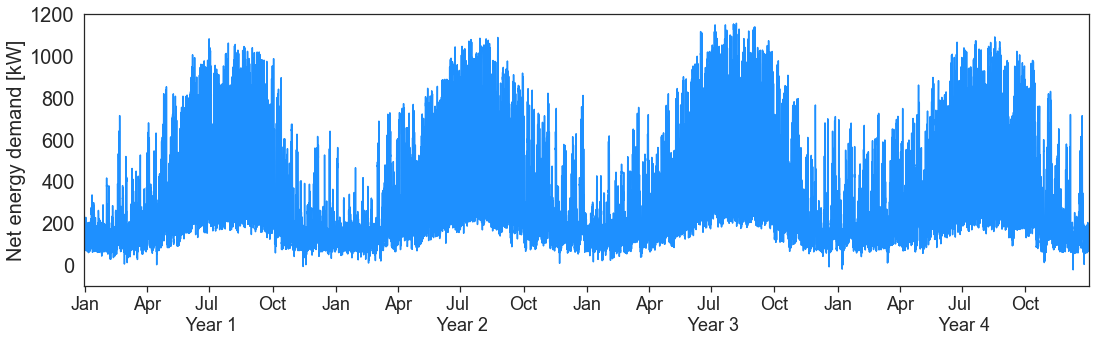

In [27]:
# import matplotlib.dates as mdates
# import matplotlib.ticker as ticker
import datetime
from turtle import width
from matplotlib.dates import DateFormatter

date_form = DateFormatter("%b")
from green_city.utils import index2datetime, datetime2index

sns.set(font="Arial")
sns.set_style("white")

df_plot = df.copy()
df_plot = df_plot.reset_index()
df_plot['id'] = df_plot.index

fontsize=20
fig, ax = plt.subplots(figsize=(18,5))
ax.tick_params(axis='x', which='major', bottom=True)

sns.lineplot(data=df_plot, y="net_load_kW", x='id', ci=None, color="dodgerblue")
plt.xticks([datetime2index(datetime.datetime(2008, 1, 2)), 
            datetime2index(datetime.datetime(2008, 4, 1)),
            datetime2index(datetime.datetime(2008, 7, 1)),
            datetime2index(datetime.datetime(2008, 10, 1)),
            datetime2index(datetime.datetime(2009, 1, 1)),
            datetime2index(datetime.datetime(2009, 4, 1)),
            datetime2index(datetime.datetime(2009, 7, 1)),
            datetime2index(datetime.datetime(2009, 10, 1)),
            datetime2index(datetime.datetime(2010, 1, 1)),
            datetime2index(datetime.datetime(2010, 4, 1)),
            datetime2index(datetime.datetime(2010, 7, 1)),
            datetime2index(datetime.datetime(2010, 10, 1)),
            datetime2index(datetime.datetime(2011, 1, 1)),
            datetime2index(datetime.datetime(2011, 4, 1)),
            datetime2index(datetime.datetime(2011, 7, 1)),
            datetime2index(datetime.datetime(2011, 10, 1)),
            ],
            ["Jan", "Apr", "Jul \n Year 1", "Oct",
            "Jan", "Apr", "Jul \n Year 2", "Oct",
            "Jan", "Apr", "Jul \n Year 3", "Oct",
            "Jan", "Apr", "Jul \n Year 4", "Oct",
            ], fontsize=fontsize-2)
plt.xlim(-24, df_plot["id"].iloc[-1])
plt.ylim(-100,1200)
plt.xlabel("",fontsize=fontsize)
plt.ylabel("Net energy demand [kW]",fontsize=fontsize)
plt.yticks(fontsize=fontsize)

#df_plot['net_load_kW'].rolling(30*24).mean().plot(ax=ax)
plt.show()


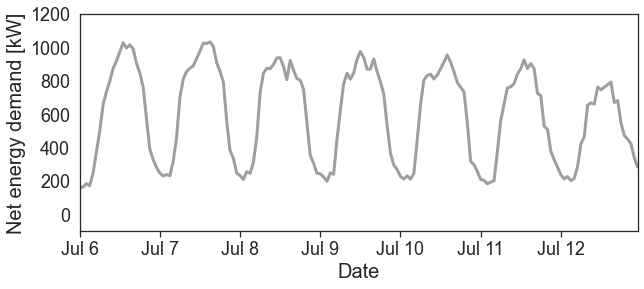

In [28]:
fig, ax = plt.subplots(figsize=(10,4))
df['net_load_kW'].loc['2009-07-06':'2009-07-12'].plot(ax=ax, color="#9e9e9e", linewidth=3)
plt.ylim(-100,1200)
plt.xlabel("Date",fontsize=fontsize)
plt.ylabel("Net energy demand [kW]",fontsize=fontsize)
ax.tick_params(axis='x', which='major', bottom=True)
plt.xticks([datetime.datetime(2009, 7, 6),
            datetime.datetime(2009, 7, 7),
            datetime.datetime(2009, 7, 8),
            datetime.datetime(2009, 7, 9),
            datetime.datetime(2009, 7, 10),
            datetime.datetime(2009, 7, 11),
            datetime.datetime(2009, 7, 12),
            ],
            ["Jul 6","Jul 7","Jul 8","Jul 9","Jul 10", "Jul 11", "Jul 12"],
            fontsize=fontsize-2)
plt.yticks(fontsize=fontsize-2)
plt.show()
fig.savefig('assets/signal_zoomedin.png')


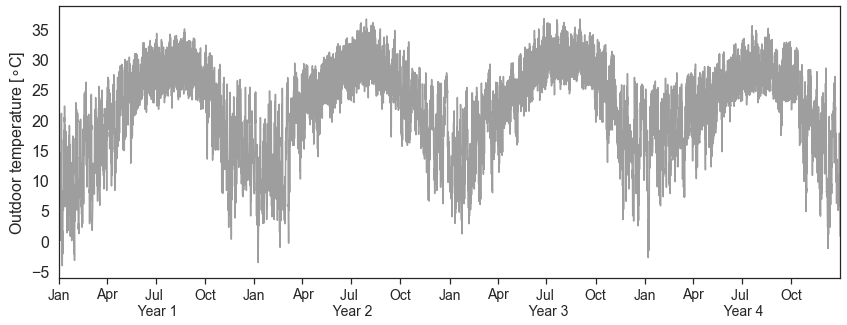

In [144]:
# import matplotlib.dates as mdates
# import matplotlib.ticker as ticker
import datetime
from turtle import width
from matplotlib.dates import DateFormatter

date_form = DateFormatter("%b")
from green_city.utils import index2datetime, datetime2index

sns.set(font="Arial")
sns.set_style("white")

df_plot = df.copy()
df_plot = df_plot.reset_index()
df_plot['id'] = df_plot.index

fontsize=16
fig, ax = plt.subplots(figsize=(14,5))
ax.tick_params(axis='x', which='major', bottom=True)

sns.lineplot(data=df_plot, y="outdoor_temp", x='id', ci=None, color="#9e9e9e")
plt.xticks([datetime2index(datetime.datetime(2008, 1, 2)), 
            datetime2index(datetime.datetime(2008, 4, 1)),
            datetime2index(datetime.datetime(2008, 7, 1)),
            datetime2index(datetime.datetime(2008, 10, 1)),
            datetime2index(datetime.datetime(2009, 1, 1)),
            datetime2index(datetime.datetime(2009, 4, 1)),
            datetime2index(datetime.datetime(2009, 7, 1)),
            datetime2index(datetime.datetime(2009, 10, 1)),
            datetime2index(datetime.datetime(2010, 1, 1)),
            datetime2index(datetime.datetime(2010, 4, 1)),
            datetime2index(datetime.datetime(2010, 7, 1)),
            datetime2index(datetime.datetime(2010, 10, 1)),
            datetime2index(datetime.datetime(2011, 1, 1)),
            datetime2index(datetime.datetime(2011, 4, 1)),
            datetime2index(datetime.datetime(2011, 7, 1)),
            datetime2index(datetime.datetime(2011, 10, 1)),
            ],
            ["Jan", "Apr", "Jul \n Year 1", "Oct",
            "Jan", "Apr", "Jul \n Year 2", "Oct",
            "Jan", "Apr", "Jul \n Year 3", "Oct",
            "Jan", "Apr", "Jul \n Year 4", "Oct",
            ], fontsize=fontsize-2)
plt.xlim(0, df_plot["id"].iloc[-1])
#plt.ylim(-100,1200)
plt.xlabel("",fontsize=fontsize)
plt.ylabel("Outdoor temperature [$\circ$C]",fontsize=fontsize)
plt.yticks(fontsize=fontsize)

#df_plot['net_load_kW'].rolling(30*24).mean().plot(ax=ax)
plt.show()


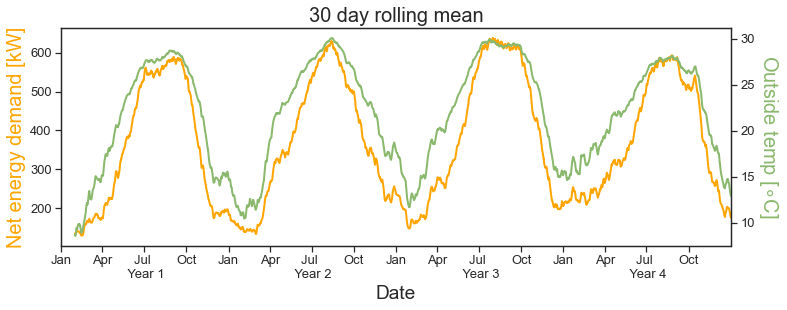

In [143]:
fontsize = 20
fig, ax = plt.subplots(figsize=(12,4))
ax2=ax.twinx()
df['net_load_kW'].rolling(24*30).mean().plot(ax=ax, color='orange', linewidth=2)
df['outdoor_temp'].rolling(24*30).mean().plot(ax=ax2, color='#8AB86D', linewidth=2)
plt.title("30 day rolling mean", fontsize=fontsize)
plt.xticks([datetime.datetime(2008, 1, 2), 
            datetime.datetime(2008, 4, 1),
            datetime.datetime(2008, 7, 1),
            datetime.datetime(2008, 10, 1),
            datetime.datetime(2009, 1, 1),
            datetime.datetime(2009, 4, 1),
            datetime.datetime(2009, 7, 1),
            datetime.datetime(2009, 10, 1),
            datetime.datetime(2010, 1, 1),
            datetime.datetime(2010, 4, 1),
            datetime.datetime(2010, 7, 1),
            datetime.datetime(2010, 10, 1),
            datetime.datetime(2011, 1, 1),
            datetime.datetime(2011, 4, 1),
            datetime.datetime(2011, 7, 1),
            datetime.datetime(2011, 10, 1)],
            ["Jan", "Apr", "Jul \n Year 1", "Oct",
            "Jan", "Apr", "Jul \n Year 2", "Oct",
            "Jan", "Apr", "Jul \n Year 3", "Oct",
            "Jan", "Apr", "Jul \n Year 4", "Oct"])
ax.tick_params(axis='both', which='major', bottom=True, labelsize=13)
ax.tick_params(axis='both', which='minor', labelsize=13)
ax2.tick_params(axis='both', which='major', labelsize=13)
ax2.tick_params(axis='both', which='minor', labelsize=13)
ax.set_ylabel("Net energy demand [kW]",color="orange",fontsize=fontsize)
ax2.set_ylabel("Outside temp [$\circ$C]",color="#8AB86D",fontsize=fontsize, rotation=270, labelpad=25)
ax.set_xlabel('Date', fontsize=fontsize-1)
plt.show()

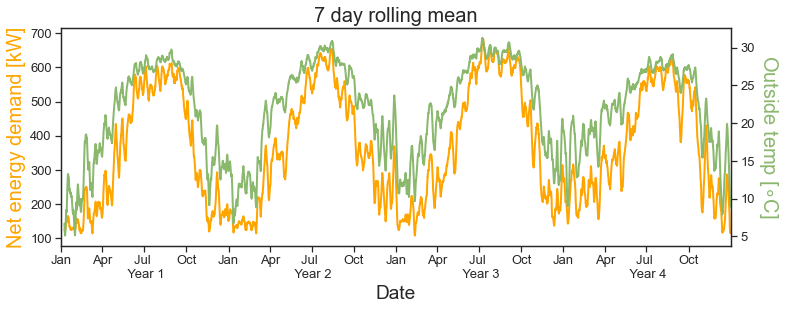

In [137]:
fontsize = 20
fig, ax = plt.subplots(figsize=(12,4))
ax2=ax.twinx()
df['net_load_kW'].rolling(24*7).mean().plot(ax=ax, color='orange', linewidth=2)
df['outdoor_temp'].rolling(24*7).mean().plot(ax=ax2, color='#8AB86D', linewidth=2)
plt.title("7 day rolling mean", fontsize=fontsize)
plt.xticks([datetime.datetime(2008, 1, 2), 
            datetime.datetime(2008, 4, 1),
            datetime.datetime(2008, 7, 1),
            datetime.datetime(2008, 10, 1),
            datetime.datetime(2009, 1, 1),
            datetime.datetime(2009, 4, 1),
            datetime.datetime(2009, 7, 1),
            datetime.datetime(2009, 10, 1),
            datetime.datetime(2010, 1, 1),
            datetime.datetime(2010, 4, 1),
            datetime.datetime(2010, 7, 1),
            datetime.datetime(2010, 10, 1),
            datetime.datetime(2011, 1, 1),
            datetime.datetime(2011, 4, 1),
            datetime.datetime(2011, 7, 1),
            datetime.datetime(2011, 10, 1)],
            ["Jan", "Apr", "Jul \n Year 1", "Oct",
            "Jan", "Apr", "Jul \n Year 2", "Oct",
            "Jan", "Apr", "Jul \n Year 3", "Oct",
            "Jan", "Apr", "Jul \n Year 4", "Oct"])
ax.tick_params(axis='both', which='major', bottom=True, labelsize=13)
ax.tick_params(axis='both', which='minor', labelsize=13)
ax2.tick_params(axis='both', which='major', labelsize=13)
ax2.tick_params(axis='both', which='minor', labelsize=13)
ax.set_ylabel("Net energy demand [kW]",color="orange",fontsize=fontsize)
ax2.set_ylabel("Outside temp [$\circ$C]",color="#8AB86D",fontsize=fontsize, rotation=270, labelpad=25)
ax.set_xlabel('Date', fontsize=fontsize-1)
plt.show()

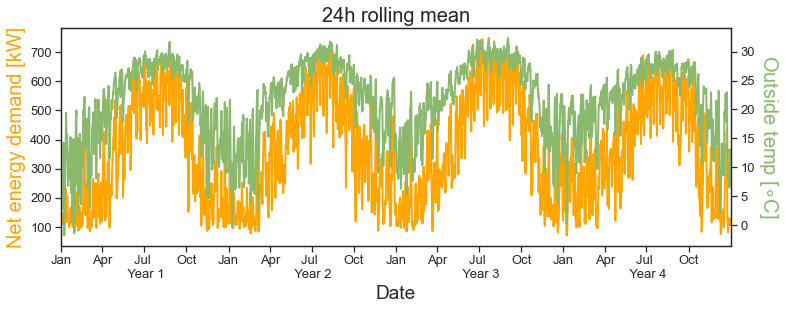

In [141]:
fontsize = 20
fig, ax = plt.subplots(figsize=(12,4))
ax2=ax.twinx()
df['net_load_kW'].rolling(24).mean().plot(ax=ax, color='orange', linewidth=2)
df['outdoor_temp'].rolling(24).mean().plot(ax=ax2, color='#8AB86D', linewidth=2)
plt.title("24h rolling mean", fontsize=fontsize)
plt.xticks([datetime.datetime(2008, 1, 2), 
            datetime.datetime(2008, 4, 1),
            datetime.datetime(2008, 7, 1),
            datetime.datetime(2008, 10, 1),
            datetime.datetime(2009, 1, 1),
            datetime.datetime(2009, 4, 1),
            datetime.datetime(2009, 7, 1),
            datetime.datetime(2009, 10, 1),
            datetime.datetime(2010, 1, 1),
            datetime.datetime(2010, 4, 1),
            datetime.datetime(2010, 7, 1),
            datetime.datetime(2010, 10, 1),
            datetime.datetime(2011, 1, 1),
            datetime.datetime(2011, 4, 1),
            datetime.datetime(2011, 7, 1),
            datetime.datetime(2011, 10, 1)],
            ["Jan", "Apr", "Jul \n Year 1", "Oct",
            "Jan", "Apr", "Jul \n Year 2", "Oct",
            "Jan", "Apr", "Jul \n Year 3", "Oct",
            "Jan", "Apr", "Jul \n Year 4", "Oct"])
ax.tick_params(axis='both', which='major', bottom=True, labelsize=13)
ax.tick_params(axis='both', which='minor', labelsize=13)
ax2.tick_params(axis='both', which='major', labelsize=13)
ax2.tick_params(axis='both', which='minor', labelsize=13)
ax.set_ylabel("Net energy demand [kW]",color="orange",fontsize=fontsize)
ax2.set_ylabel("Outside temp [$\circ$C]",color="#8AB86D",fontsize=fontsize, rotation=270, labelpad=25)
ax.set_xlabel('Date', fontsize=fontsize-1)
plt.show()

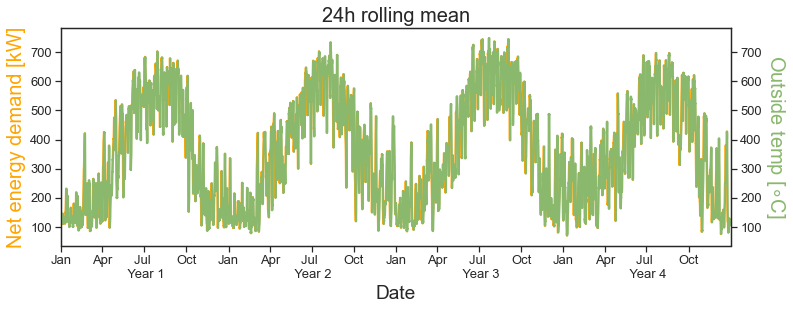

In [147]:
fontsize = 20
fig, ax = plt.subplots(figsize=(12,4))
ax2=ax.twinx()
df['net_load_kW'].rolling(24).mean().plot(ax=ax, color='orange', linewidth=2)
df['net_load_kW_lag24'].rolling(24).mean().plot(ax=ax2, color='#8AB86D', linewidth=2)
plt.title("24h rolling mean", fontsize=fontsize)
plt.xticks([datetime.datetime(2008, 1, 2), 
            datetime.datetime(2008, 4, 1),
            datetime.datetime(2008, 7, 1),
            datetime.datetime(2008, 10, 1),
            datetime.datetime(2009, 1, 1),
            datetime.datetime(2009, 4, 1),
            datetime.datetime(2009, 7, 1),
            datetime.datetime(2009, 10, 1),
            datetime.datetime(2010, 1, 1),
            datetime.datetime(2010, 4, 1),
            datetime.datetime(2010, 7, 1),
            datetime.datetime(2010, 10, 1),
            datetime.datetime(2011, 1, 1),
            datetime.datetime(2011, 4, 1),
            datetime.datetime(2011, 7, 1),
            datetime.datetime(2011, 10, 1)],
            ["Jan", "Apr", "Jul \n Year 1", "Oct",
            "Jan", "Apr", "Jul \n Year 2", "Oct",
            "Jan", "Apr", "Jul \n Year 3", "Oct",
            "Jan", "Apr", "Jul \n Year 4", "Oct"])
ax.tick_params(axis='both', which='major', bottom=True, labelsize=13)
ax.tick_params(axis='both', which='minor', labelsize=13)
ax2.tick_params(axis='both', which='major', labelsize=13)
ax2.tick_params(axis='both', which='minor', labelsize=13)
ax.set_ylabel("Net energy demand [kW]",color="orange",fontsize=fontsize)
ax2.set_ylabel("Outside temp [$\circ$C]",color="#8AB86D",fontsize=fontsize, rotation=270, labelpad=25)
ax.set_xlabel('Date', fontsize=fontsize-1)
plt.show()

### Hourly usage breakdown in summer/winter

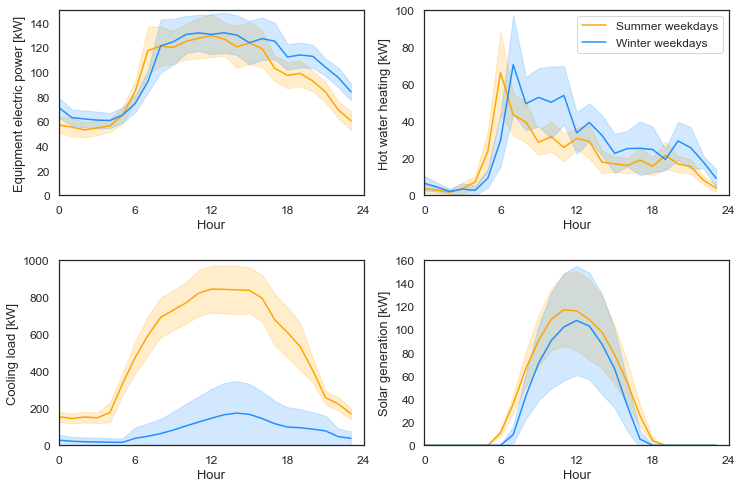

In [31]:
ci = "sd"
fontsize=13
sns.set(font="Arial")
sns.set_style("white")

fig, ax = plt.subplots(2,2,figsize=(12,8))
plt.subplot(2, 2, 1)
col = "equipment_electric_power_kW"
sns.lineplot(data=df_weekday_sum, y=col, x='hour', color='orange', ci=ci)
sns.lineplot(data=df_weekday_win, y=col, x='hour', color='dodgerblue', ci=ci)
plt.ylabel('Equipment electric power [kW]', fontsize=fontsize)
plt.xlabel('Hour', fontsize=fontsize)
plt.xticks([0, 6, 12, 18, 24], fontsize=fontsize-1)
plt.xlim(0,24)
plt.ylim(0,150)
plt.yticks(fontsize=fontsize-1)

plt.subplot(2, 2, 2)
col = "dhw_heating_kW"
sns.lineplot(data=df_weekday_sum, y=col, x='hour', color='orange', ci=ci, label="Summer weekdays")
sns.lineplot(data=df_weekday_win, y=col, x='hour', color='dodgerblue', ci=ci, label="Winter weekdays")
plt.ylabel('Hot water heating [kW]', fontsize=fontsize)
plt.xlabel('Hour', fontsize=fontsize)
plt.legend(fontsize=fontsize-1, loc='upper right')
plt.xticks([0, 6, 12, 18, 24], fontsize=fontsize-1)
plt.xlim(0,24)
plt.ylim(0,100)
plt.yticks(fontsize=fontsize-1)

plt.subplot(2, 2, 3)
col = "cooling_load_kW"
sns.lineplot(data=df_weekday_sum, y=col, x='hour', color='orange', ci=ci)
sns.lineplot(data=df_weekday_win, y=col, x='hour', color='dodgerblue', ci=ci)
plt.ylabel('Cooling load [kW]', fontsize=fontsize)
plt.xlabel('Hour', fontsize=fontsize)
plt.xticks([0, 6, 12, 18, 24], fontsize=fontsize-1)
plt.xlim(0,24)
plt.ylim(0,1000)
plt.yticks(fontsize=fontsize-1)

plt.subplot(2, 2, 4)
col = "solar_generation_kW"
sns.lineplot(data=df_weekday_sum, y=col, x='hour', color='orange', ci=ci)
sns.lineplot(data=df_weekday_win, y=col, x='hour', color='dodgerblue', ci=ci)
plt.ylabel('Solar generation [kW]', fontsize=fontsize)
plt.xlabel('Hour', fontsize=fontsize)
plt.xticks([0, 6, 12, 18, 24], fontsize=fontsize-1)
plt.yticks(fontsize=fontsize-1)
plt.xlim(0,24)
plt.ylim(0,160)

plt.subplots_adjust(hspace=0.35)
plt.show()
fig.savefig('assets/usagebreakdown_seasons_aggbuildings.png')


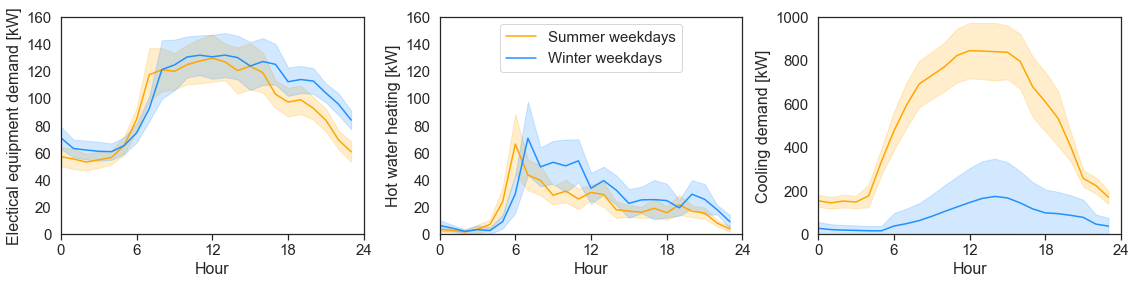

In [32]:
ci = "sd"
fontsize=16
xticks = [0, 6, 12, 18, 24]
xlim = (0, 24)
ylim = (0, 1000)

sns.set(font="Arial")
sns.set_style("white")

fig, ax = plt.subplots(1,3,figsize=(19,4))
plt.subplot(1, 3, 1)
col = "equipment_electric_power_kW"
sns.lineplot(data=df_weekday_sum, y=col, x='hour', color='orange', ci=ci)
sns.lineplot(data=df_weekday_win, y=col, x='hour', color='dodgerblue', ci=ci)
plt.ylabel('Electical equipment demand [kW]', fontsize=fontsize)
plt.xlabel('Hour', fontsize=fontsize)
plt.xticks(xticks, fontsize=fontsize-1)
plt.yticks(fontsize=fontsize-1)
plt.xlim(xlim)
plt.ylim(0,160)
plt.tick_params(axis='x', which='major', bottom=True)

plt.subplot(1, 3, 2)
col = "dhw_heating_kW"
sns.lineplot(data=df_weekday_sum, y=col, x='hour', color='orange', ci=ci, label='Summer weekdays')
sns.lineplot(data=df_weekday_win, y=col, x='hour', color='dodgerblue', ci=ci, label='Winter weekdays')
plt.ylabel('Hot water heating [kW]', fontsize=fontsize)
plt.xlabel('Hour', fontsize=fontsize)
plt.xticks(xticks, fontsize=fontsize-1)
plt.yticks(fontsize=fontsize-1)
plt.xlim(xlim)
plt.ylim(0,160)
plt.legend(loc='upper center', fontsize=fontsize-1)
plt.tick_params(axis='x', which='major', bottom=True)

plt.subplot(1, 3, 3)
col = "cooling_load_kW"
sns.lineplot(data=df_weekday_sum, y=col, x='hour', color='orange', ci=ci)
sns.lineplot(data=df_weekday_win, y=col, x='hour', color='dodgerblue', ci=ci)
plt.ylabel('Cooling demand [kW]', fontsize=fontsize)
plt.xlabel('Hour', fontsize=fontsize)
plt.xticks(xticks, fontsize=fontsize-1)
plt.tick_params(axis='x', which='major', bottom=True)
plt.yticks(fontsize=fontsize-1)
plt.xlim(xlim)
plt.ylim(ylim)

#plt.suptitle('Building '+str(building_nr))
plt.subplots_adjust(wspace=0.25)
plt.show()
#fig.savefig('assets/netusage_building_'+str(building_nr)+'.png')


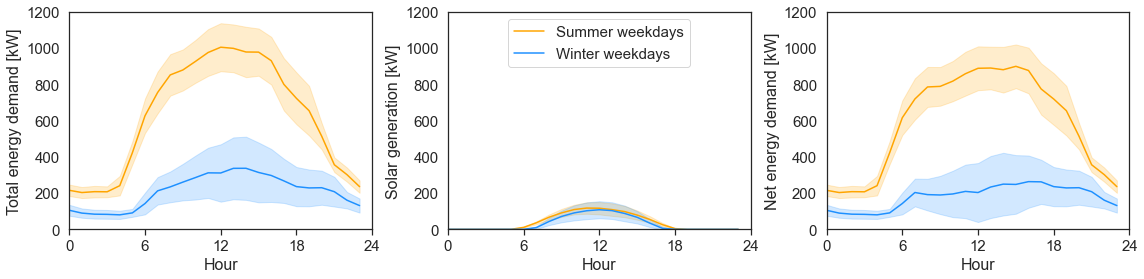

In [33]:
ci = "sd"
fontsize=16
xticks = [0, 6, 12, 18, 24]
xlim = (0, 24)
ylim = (0, 1200)

sns.set(font="Arial")
sns.set_style("white")

fig, ax = plt.subplots(1,3,figsize=(19,4))
plt.subplot(1, 3, 1)
col = "total_load_kW"
sns.lineplot(data=df_weekday_sum, y=col, x='hour', color='orange', ci=ci)
sns.lineplot(data=df_weekday_win, y=col, x='hour', color='dodgerblue', ci=ci)
plt.ylabel('Total energy demand [kW]', fontsize=fontsize)
plt.xlabel('Hour', fontsize=fontsize)
plt.xticks(xticks, fontsize=fontsize-1)
plt.yticks(fontsize=fontsize-1)
plt.xlim(xlim)
plt.ylim(ylim)
plt.tick_params(axis='x', which='major', bottom=True)

plt.subplot(1, 3, 2)
col = "solar_generation_kW"
sns.lineplot(data=df_weekday_sum, y=col, x='hour', color='orange', ci=ci, label='Summer weekdays')
sns.lineplot(data=df_weekday_win, y=col, x='hour', color='dodgerblue', ci=ci, label='Winter weekdays')
plt.ylabel('Solar generation [kW]', fontsize=fontsize)
plt.xlabel('Hour', fontsize=fontsize)
plt.xticks(xticks, fontsize=fontsize-1)
plt.yticks(fontsize=fontsize-1)
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend(loc='upper center', fontsize=fontsize-1)
plt.tick_params(axis='x', which='major', bottom=True)

plt.subplot(1, 3, 3)
col = "net_load_kW"
sns.lineplot(data=df_weekday_sum, y=col, x='hour', color='orange', ci=ci)
sns.lineplot(data=df_weekday_win, y=col, x='hour', color='dodgerblue', ci=ci)
plt.ylabel('Net energy demand [kW]', fontsize=fontsize)
plt.xlabel('Hour', fontsize=fontsize)
plt.xticks(xticks, fontsize=fontsize-1)
plt.tick_params(axis='x', which='major', bottom=True)
plt.yticks(fontsize=fontsize-1)
plt.xlim(xlim)
plt.ylim(ylim)

#plt.suptitle('Building '+str(building_nr))
plt.subplots_adjust(wspace=0.25)
plt.show()
fig.savefig('assets/netusage_building_'+str(building_nr)+'.png')


### Net usage  in summer/winter

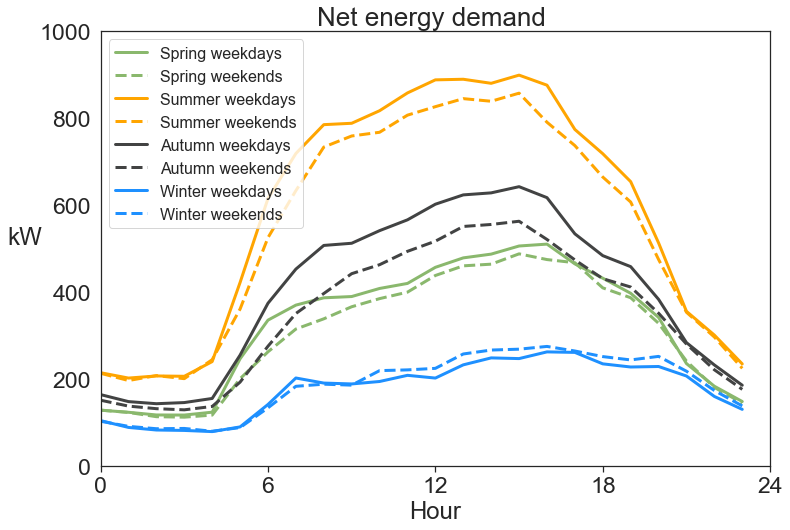

In [92]:
sns.set(font="Verdana")
sns.set_style("white")

ci = None
fontsize=24
xticks = [0, 6, 12, 18, 24]
xlim = (0, 24)
ylim = (0, 1000)
fig, ax = plt.subplots(figsize=(12,8))
col = "net_load_kW"

sns.lineplot(data=df_weekday_spr, y=col, x='hour', color='#8AB86D', linewidth=3, ci=ci, label="Spring weekdays")
sns.lineplot(data=df_weekend_spr, y=col, x='hour', color='#8AB86D', linewidth=3, linestyle='--', ci=ci, label="Spring weekends")

sns.lineplot(data=df_weekday_sum, y=col, x='hour', color='orange', linewidth=3, ci=ci, label="Summer weekdays")
sns.lineplot(data=df_weekend_sum, y=col, x='hour', color='orange', linewidth=3, linestyle='--', ci=ci, label="Summer weekends")

sns.lineplot(data=df_weekday_aut, y=col, x='hour', color='#424343', linewidth=3, ci=ci, label="Autumn weekdays")
sns.lineplot(data=df_weekend_aut, y=col, x='hour', color='#424343', linewidth=3, linestyle='--', ci=ci, label="Autumn weekends")


sns.lineplot(data=df_weekday_win, y=col, x='hour', color='dodgerblue', linewidth=3, ci=ci, label="Winter weekdays")
sns.lineplot(data=df_weekend_win, y=col, x='hour', color='dodgerblue', linewidth=3, linestyle='--', ci=ci, label="Winter weekends")

plt.rcParams.update({'font.family':'Arial'})

plt.xlim(xlim)
plt.ylim(ylim)
plt.ylabel('kW', fontsize=fontsize, rotation=0, labelpad=15)
plt.xlabel('Hour', fontsize=fontsize)
plt.title('Net energy demand ', fontsize=fontsize+2)
plt.xticks(xticks, fontsize=fontsize-1)
plt.tick_params(axis='x', which='major', bottom=True)
plt.yticks(fontsize=fontsize-1)
plt.legend(loc='upper left', fontsize=fontsize-8)
plt.show()
#fig.savefig('assets/netusage_seasons.png')


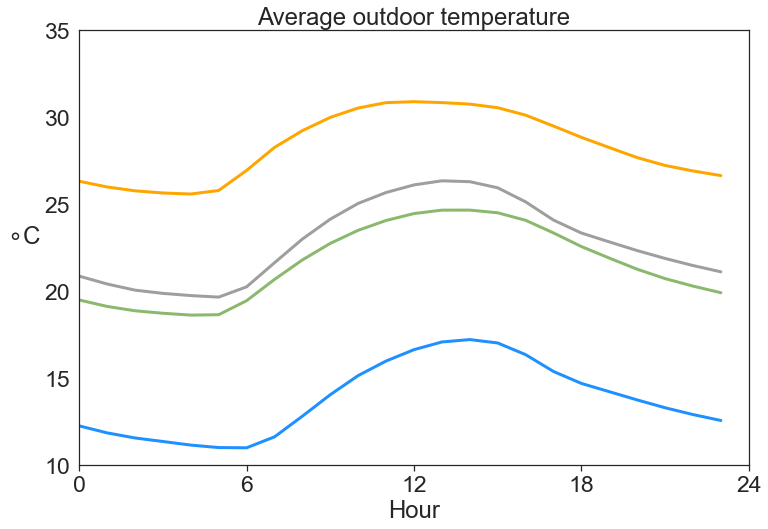

In [98]:
ci = None
fontsize=24
xticks = [0, 6, 12, 18, 24]
xlim = (0, 24)
ylim = (0, 1000)

sns.set(font="Arial")
sns.set_style("white")
plt.rcParams.update({'font.family':'Arial'})
fig, ax = plt.subplots(figsize=(12,8))
col = "outdoor_temp"

sns.lineplot(data=df_spring, y=col, x='hour', color='#8AB86D', linewidth=3, ci=ci)
sns.lineplot(data=df_summer, y=col, x='hour', color='orange', linewidth=3, ci=ci)
sns.lineplot(data=df_autumn, y=col, x='hour', color='#9e9e9e', linewidth=3, ci=ci)
sns.lineplot(data=df_winter, y=col, x='hour', color='dodgerblue', linewidth=3, ci=ci)

plt.xlim(xlim)
plt.ylim(10,35)
plt.ylabel('$\circ$C', fontsize=fontsize, rotation=0, labelpad=20)
plt.title('Average outdoor temperature', fontsize=fontsize)
plt.xlabel('Hour', fontsize=fontsize)
plt.xticks(xticks, fontsize=fontsize-1)
plt.tick_params(axis='x', which='major', bottom=True)
plt.tick_params(axis='y', which='major', bottom=True)
plt.yticks(fontsize=fontsize-1)
#plt.legend(loc='upper left', fontsize=fontsize-4)
plt.show()
#fig.savefig('assets/netusage_seasons.png')



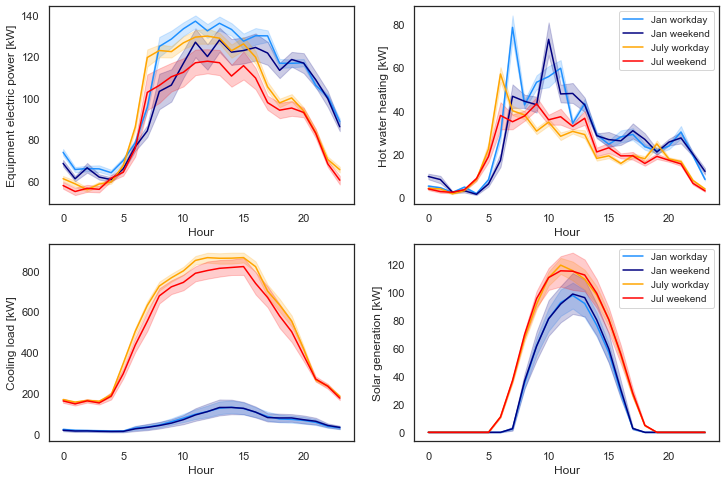

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(12,8))
plt.subplot(2, 2, 1)
col = "equipment_electric_power_kW"
sns.lineplot(data=df_workday_jan, y=col, x='hour', color='dodgerblue')
sns.lineplot(data=df_weekend_jan, y=col, x='hour', color='navy')
sns.lineplot(data=df_workday_jul, y=col, x='hour', color='orange')
sns.lineplot(data=df_weekend_jul, y=col, x='hour', color='red')
plt.ylabel('Equipment electric power [kW]')
plt.xlabel('Hour')
#plt.legend(fontsize=10, loc='upper right')

plt.subplot(2, 2, 2)
col = "dhw_heating_kW"
sns.lineplot(data=df_workday_jan, y=col, x='hour', label="Jan workday", color='dodgerblue')
sns.lineplot(data=df_weekend_jan, y=col, x='hour', label="Jan weekend", color='navy')
sns.lineplot(data=df_workday_jul, y=col, x='hour', label="July workday", color='orange')
sns.lineplot(data=df_weekend_jul, y=col, x='hour', label="Jul weekend", color='red')
plt.ylabel('Hot water heating [kW]')
plt.xlabel('Hour')
plt.legend(fontsize=10, loc='upper right')

plt.subplot(2, 2, 3)
col = "cooling_load_kW"
sns.lineplot(data=df_workday_jan, y=col, x='hour', color='dodgerblue')
sns.lineplot(data=df_weekend_jan, y=col, x='hour', color='navy')
sns.lineplot(data=df_workday_jul, y=col, x='hour', color='orange')
sns.lineplot(data=df_weekend_jul, y=col, x='hour', color='red')
plt.ylabel('Cooling load [kW]')
plt.xlabel('Hour')

plt.subplot(2, 2, 4)
col = "solar_generation_kW"
sns.lineplot(data=df_workday_jan, y=col, x='hour', label="Jan workday", color='dodgerblue')
sns.lineplot(data=df_weekend_jan, y=col, x='hour', label="Jan weekend", color='navy')
sns.lineplot(data=df_workday_jul, y=col, x='hour', label="July workday", color='orange')
sns.lineplot(data=df_weekend_jul, y=col, x='hour', label="Jul weekend", color='red')
plt.ylabel('Solar generation [kW]')
plt.xlabel('Hour')
plt.legend(fontsize=10, loc='upper right')

plt.show()

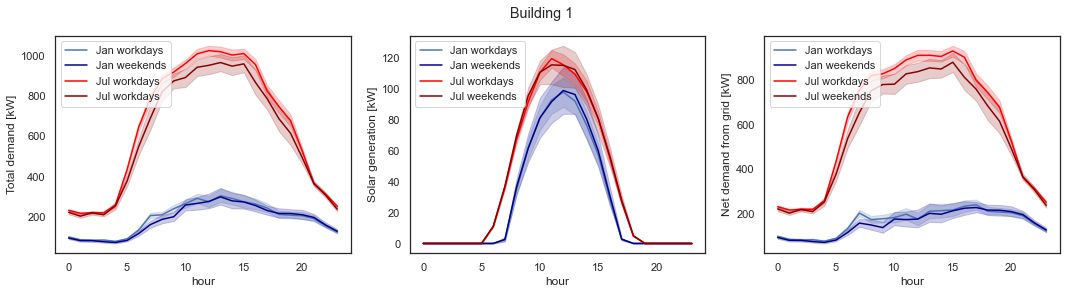

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(18,4))
plt.subplot(1, 3, 1)
col = "total_load_kW"
sns.lineplot(data=df_workday_jan, y=col, x='hour', label="Jan workdays")
sns.lineplot(data=df_weekend_jan, y=col, x='hour', label="Jan weekends", color="darkblue")

sns.lineplot(data=df_workday_jul, y=col, x='hour', label="Jul workdays", color="red")
sns.lineplot(data=df_weekend_jul, y=col, x='hour', label="Jul workdays", color="darkred")
plt.ylabel('Total demand [kW]')
plt.legend(loc='upper left')
#plt.ylim(0,80)

plt.subplot(1, 3, 2)
col = "solar_generation_kW"
sns.lineplot(data=df_workday_jan, y=col, x='hour', label="Jan workdays")
sns.lineplot(data=df_weekend_jan, y=col, x='hour', label="Jan weekends", color="darkblue")
sns.lineplot(data=df_workday_jul, y=col, x='hour', label="Jul workdays", color="red")
sns.lineplot(data=df_weekend_jul, y=col, x='hour', label="Jul weekends", color="darkred")
plt.ylabel('Solar generation [kW]')
plt.legend(loc='upper left')

plt.subplot(1, 3, 3)
col = "net_load_kW"
sns.lineplot(data=df_workday_jan, y=col, x='hour', label="Jan workdays")
sns.lineplot(data=df_weekend_jan, y=col, x='hour', label="Jan weekends", color="darkblue")
sns.lineplot(data=df_workday_jul, y=col, x='hour', label="Jul workdays", color="red")
sns.lineplot(data=df_weekend_jul, y=col, x='hour', label="Jul weekends", color="darkred")
plt.ylabel('Net demand from grid [kW]')
plt.legend(loc='upper left')
#plt.ylim(0,80)

fig.suptitle('Building 1')
plt.show()

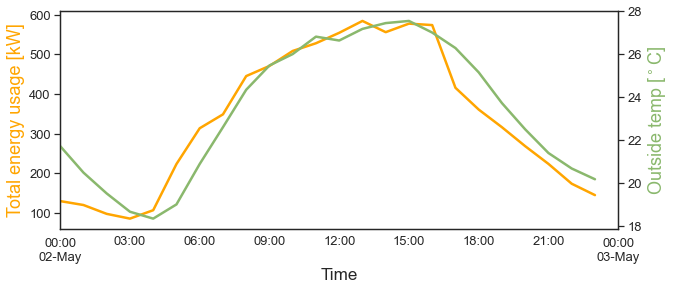

In [ ]:
ci = None
fontsize=18
fig, ax = plt.subplots(figsize=(10,4))
plt.rcParams["font.family"] = "Arial"

ax2=ax.twinx()
df['total_load_kW'].loc['2009-05-02'].plot(ax=ax, color='orange', linewidth=2.5)
df['outdoor_temp'].loc['2009-05-02'].plot(ax=ax2, color='#8AB86D', linewidth=2.5)
ax.set_ylabel("Total energy usage [kW]",color="orange",fontsize=fontsize)
ax2.set_ylabel("Outside temp [$^\circ$C]",color="#8AB86D",fontsize=fontsize)
ax.set_xlabel('Time', fontsize=fontsize-1)
#ax.set_ylim(0,70)
ax.set_xlim('2009-05-02 00:00','2009-05-03 00:00')
ax.tick_params(axis='both', which='major', labelsize=13)
ax.tick_params(axis='both', which='minor', labelsize=13)
ax2.tick_params(axis='both', which='major', labelsize=13)
ax2.tick_params(axis='both', which='minor', labelsize=13)
plt.show()


fig.savefig('assets/goal.png')



### Average total load by month for Building 4 (with cooling)

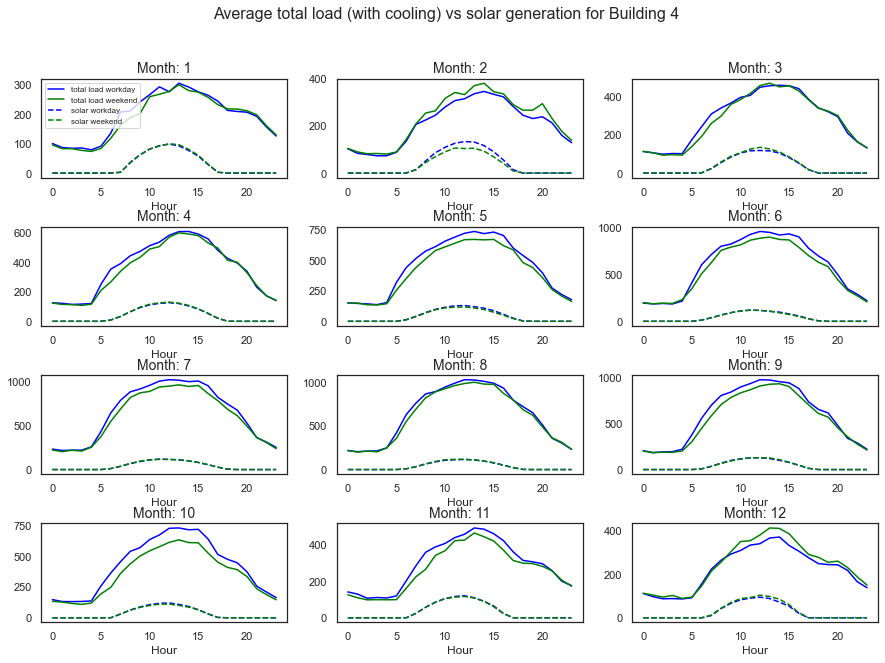

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(15,10))

for month in range(1,13):

    # Group by workdays
    df_workday = df[(df.index.month == month) & (df.workday == True)]

    # Group by weekends/holidays
    df_weekend = df[(df.index.month == month) & (df.workday == False)]

    plt.subplot(4, 3, month)
    col = "total_load_kW"
    df_workday.groupby(df_workday.index.hour)[col].mean().plot(label="total load workday", color="blue")
    df_weekend.groupby(df_weekend.index.hour)[col].mean().plot(label="total load weekend", color="green")

    col = "solar_generation_kW"
    df_workday.groupby(df_workday.index.hour)[col].mean().plot(label="solar workday", color="blue", linestyle='--')
    df_weekend.groupby(df_weekend.index.hour)[col].mean().plot(label="solar weekend", color="green", linestyle='--')
    plt.xlabel('Hour')
    if month == 1:
        plt.legend(fontsize=8)
    plt.title('Month: '+str(month), fontsize=14)
fig.suptitle('Average total load (with cooling) vs solar generation for Building 4', fontsize=16)
plt.subplots_adjust(hspace=0.5)
plt.show()

Text(0.5, 0, 'Building number')

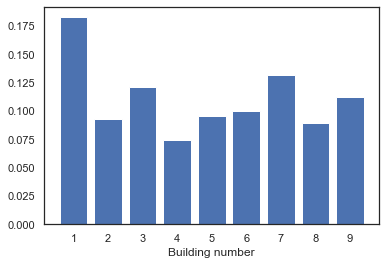

In [163]:
total_demand = []
for building_nr in range(1,10):
    df = pd.read_csv(f"../data/preprocessed/Building_{building_nr}.csv").astype({'datetime': 'datetime64'}).set_index('datetime')
    total_demand.append(df['net_load_kW'].sum())

df = pd.read_csv(f"../data/preprocessed/Agg_buildings.csv").astype({'datetime': 'datetime64'}).set_index('datetime')
total_all = df['net_load_kW'].sum()

plt.bar(x=[1,2,3,4,5,6,7,8,9], height=total_demand/total_all)
plt.xticks([1,2,3,4,5,6,7,8,9],[1,2,3,4,5,6,7,8,9])
plt.xlabel('Building number')

Text(0.5, 0, 'Building number')

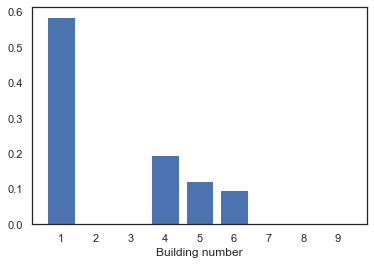

In [164]:
total_demand = []
for building_nr in range(1,10):
    df = pd.read_csv(f"../data/preprocessed/Building_{building_nr}.csv").astype({'datetime': 'datetime64'}).set_index('datetime')
    total_demand.append(df['solar_generation_kW'].sum())

df = pd.read_csv(f"../data/preprocessed/Agg_buildings.csv").astype({'datetime': 'datetime64'}).set_index('datetime')
total_all = df['solar_generation_kW'].sum()

plt.bar(x=[1,2,3,4,5,6,7,8,9], height=total_demand/total_all)
plt.xticks([1,2,3,4,5,6,7,8,9],[1,2,3,4,5,6,7,8,9])
plt.xlabel('Building number')

Text(0.5, 0, 'Building number')

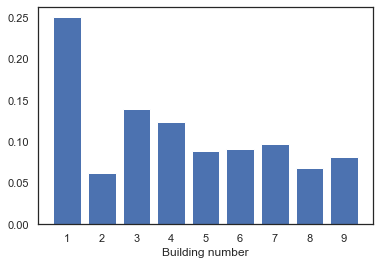

In [165]:
total_demand = []
for building_nr in range(1,10):
    df = pd.read_csv(f"../data/preprocessed/Building_{building_nr}.csv").astype({'datetime': 'datetime64'}).set_index('datetime')
    total_demand.append(df['cooling_load_kW'].sum())

df = pd.read_csv(f"../data/preprocessed/Agg_buildings.csv").astype({'datetime': 'datetime64'}).set_index('datetime')
total_all = df['cooling_load_kW'].sum()

plt.bar(x=[1,2,3,4,5,6,7,8,9], height=total_demand/total_all)
plt.xticks([1,2,3,4,5,6,7,8,9],[1,2,3,4,5,6,7,8,9])
plt.xlabel('Building number')